In [1]:
import torch
import matplotlib.pyplot as plt
import os
from models_normal import LocallyWeightedCNP,CNP,LW_VQCNP,LW_VQCNP_2
import data
from ipywidgets import interact, FloatSlider
from pathlib import Path
import pickle
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import numpy as np

In [3]:
def preprocess_and_save_keypoints(pkl_folder_path, output_folder_path):
    pkl_folder = Path(pkl_folder_path)
    output_folder = Path(output_folder_path)
    output_folder.mkdir(parents=True, exist_ok=True)  # Create the output folder if it doesn't exist

    # Initialize an empty list to hold all the curves
    data = []

    for pkl_file in pkl_folder.glob('*.pkl'):
        with open(pkl_file, 'rb') as f:
            # Load the demonstration data from the file
            demonstration = pickle.load(f)
            
            # Extract the optimized keypoints data
            keypoints3d_optim = demonstration['keypoints3d_optim']
            
            
            # Ensure the number of timesteps is 524
            num_timesteps = keypoints3d_optim.shape[0]
            if num_timesteps > 200:
                keypoints3d_optim = keypoints3d_optim[:200]
            # Select the x and y coordinates
            keypoints_xy = keypoints3d_optim[:, :, :3]  # Assuming the shape is (N, 17, 3)

            # Flatten the last two dimensions
            keypoints_flat = keypoints_xy.reshape(keypoints_xy.shape[0], -1)  # New shape (N, 34)
            
            # Generate the timesteps tensor
            timesteps = torch.linspace(0, 1, keypoints_flat.shape[0]).unsqueeze(1)

            # Concatenate timesteps with the flattened keypoints
            curve = torch.cat([timesteps, torch.tensor(keypoints_flat, dtype=torch.float32)], dim=1)

            # Append the curve to the data list
            data.append(curve.numpy())  # Convert to numpy for universal compatibility
            
            # Save the individual processed curve to a new file (optional)
            output_file_path = output_folder / f"{pkl_file.stem}_processed.pkl"
            with open(output_file_path, 'wb') as out_f:
                pickle.dump(curve.numpy(), out_f)

    # Save the entire data list to a single file
    data_pkl_path = output_folder / 'data_3d.pkl'
    with open(data_pkl_path, 'wb') as f:
        pickle.dump(data, f)



# Usage:
pkl_folder_path = '/home/colors/aist_lw/aistplusplus_api-main/3d_keypoint_pkls'
output_folder_path = '/home/colors/aist_lw/aistplusplus_api-main/3d_keypoint_pkls/processed_3d'
preprocess_and_save_keypoints(pkl_folder_path, output_folder_path)


In [12]:
from pathlib import Path
import torch
import pickle
import numpy as np

def preprocess_and_save_keypoints(pkl_folder_path, output_folder_path):
    pkl_folder = Path(pkl_folder_path)
    output_folder = Path(output_folder_path)
    output_folder.mkdir(parents=True, exist_ok=True)

    # Initialize an empty list to hold all the curves
    data = []

    # Find the maximum absolute value for normalization
    max_val = float('-inf')
    for pkl_file in pkl_folder.glob('*.pkl'):
        with open(pkl_file, 'rb') as f:
            demonstration = pickle.load(f)
            keypoints3d_optim = demonstration['keypoints3d_optim']
            if keypoints3d_optim.shape[0] > 200:
                keypoints3d_optim = keypoints3d_optim[:200]
            keypoints_xy = keypoints3d_optim[:, :, :2]
            current_max = np.abs(keypoints_xy).max()
            max_val = max(max_val, current_max)

    # Process the keypoints and normalize them
    for pkl_file in pkl_folder.glob('*.pkl'):
        with open(pkl_file, 'rb') as f:
            demonstration = pickle.load(f)
            keypoints3d_optim = demonstration['keypoints3d_optim']
            if keypoints3d_optim.shape[0] > 200:
                keypoints3d_optim = keypoints3d_optim[:200]
            keypoints_xy = keypoints3d_optim[:, :, :2]

            # Normalize the keypoints to be between -1 and 1
            keypoints_xy /= max_val

            keypoints_flat = keypoints_xy.reshape(keypoints_xy.shape[0], -1)
            timesteps = torch.linspace(0, 1, keypoints_flat.shape[0]).unsqueeze(1)
            curve = torch.cat([timesteps, torch.tensor(keypoints_flat, dtype=torch.float32)], dim=1)
            data.append(curve.numpy())

            output_file_path = output_folder / f"{pkl_file.stem}_processed.pkl"
            with open(output_file_path, 'wb') as out_f:
                pickle.dump(curve.numpy(), out_f)

    data_pkl_path = output_folder / 'data.pkl'
    with open(data_pkl_path, 'wb') as f:
        pickle.dump(data, f)

# Usage example
preprocess_and_save_keypoints(pkl_folder_path, output_folder_path)


In [3]:
!pwd

/home/colors/LW_CNMP_everything


In [4]:
# with open(output_folder_path+'/data.pkl', 'rb') as f:
#     data_dance = pickle.load(f)
# N = len(data_dance)
# N
class Dance_Dataset(data.CNPDemonstrationDataset):
    def __init__(self, data_pkl_path):
        # Load the data from the .pkl file
        with open(data_pkl_path, 'rb') as f:
            self.data = pickle.load(f)
            self.data= torch.tensor(self.data)
        self.N = len(self.data)
data_pkl_path='//home/colors/LW_CNMP_everything/3d_keypoint_pkls/processed_3d/data_3d.pkl'
dset = Dance_Dataset(data_pkl_path)
dset.data[0].shape
dset.N=2
dset.data=dset.data[[0,6]]

/tmp/ipykernel_47697/4094140572.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/torch/csrc/utils/tensor_new.cpp:245.)
  self.data= torch.tensor(self.data)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
observation=torch.stack((dset.data[1][0],dset.data[0][199])).unsqueeze(0).to(device)


In [8]:
#observation= torch.tensor([dset.data[0][0]]).unsqueeze(0)
target = torch.linspace(0.0, 1.0, 200).unsqueeze(-1).unsqueeze(0).to(device)
observation=dset.data[0][0].unsqueeze(0).to(device)
#observation=torch.stack((dset.data[1][0],dset.data[0][130])).unsqueeze(0).to(device)

with torch.no_grad():
    #model.weight_std = torch.tensor(0.5)
    mean, std = model(observation, target, locally_weighted=True,aggregation_std=0.2)
    #mean, std = model(observation, target, locally_weighted=True,aggregation_std=0.5,primitive_index=torch.tensor([0,0]).to(device))
    #mean, std = model(observation, target)
mean.squeeze_(0)
std.squeeze_(0)


NameError: name 'model' is not defined

In [88]:
%matplotlib qt
# Let's assume that 'mean' is the model's output for the keypoints predictions
# and has a shape of [200, 34] (for 200 timesteps and 17 keypoints * 2 coordinates each)
# Define the connections between keypoints for the stick figure
# These connections are based on the COCO-format keypoint definition provided
skeleton_connections = [
    (0, 1), (0, 2), (1, 3), (2, 4), # Head to ears
    (5, 6), (5, 7), (7, 9), # Left arm
    (6, 8), (8, 10), # Right arm
    (11, 12), (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 11), (6, 12), # Body (shoulder to hip)
    (5, 6), (11, 12) # Shoulders and hips
]

# COCO-format keypoint definition
keypoint_labels = [
    "nose", 
    "left_eye", "right_eye", "left_ear", "right_ear", 
    "left_shoulder", "right_shoulder", 
    "left_elbow", "right_elbow", 
    "left_wrist", "right_wrist", 
    "left_hip", "right_hip", 
    "left_knee", "right_knee", 
    "left_ankle", "right_ankle"
]
# Reshape the model's output to match the original keypoints' shape
predicted_keypoints = mean.cpu().numpy().reshape(-1, 17, 2)  # Adjust shape as per your data

# The rest of the animation code would be similar to your existing code.
# You would use 'predicted_keypoints' instead of 'reduced_frames_keypoints' to update the animation.
def animate_predictions(predictions):
    # Reshape the predictions to the original keypoints' shape if necessary
    reshaped_predictions = predictions.reshape(-1, 17, 2)

    # Create a new figure for the 2D animation
    fig, ax = plt.subplots(figsize=(10, 8))

    # Initialize the lines and annotations for the animation
    lines = [ax.plot([], [], 'ro-')[0] for _ in skeleton_connections]
    annotations = [ax.text(0, 0, keypoint_labels[i], color='blue') for i in range(len(keypoint_labels))]

    # Set the plot limits
    ax.set_xlim(np.min(reshaped_predictions[:,:,0]), np.max(reshaped_predictions[:,:,0]))
    ax.set_ylim(np.min(reshaped_predictions[:,:,1]), np.max(reshaped_predictions[:,:,1]))

    # Set the labels for the axes
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')

    # Define the update function for the animation
    def update(frame_number):
        for line, connection in zip(lines, skeleton_connections):
            point1 = reshaped_predictions[frame_number][connection[0], :]
            point2 = reshaped_predictions[frame_number][connection[1], :]
            line.set_data([point1[0], point2[0]], [point1[1], point2[1]])
        for annotation, keypoint in zip(annotations, reshaped_predictions[frame_number]):
            annotation.set_position((keypoint[0], keypoint[1]))
        return lines + annotations

    # Creating the 2D animation
    ani = FuncAnimation(fig, update, frames=len(reshaped_predictions),
                        interval=500/60, blit=True)

    # Display the animation
    plt.show()

    return ani

# Call the function with your model's output
animation = animate_predictions(predicted_keypoints)

# If you want to save the animation, you can do so with the save method:
animation.save('predicted_animation_3_2_slow.mp4', writer='ffmpeg', fps=60)


torch.Size([200, 52])


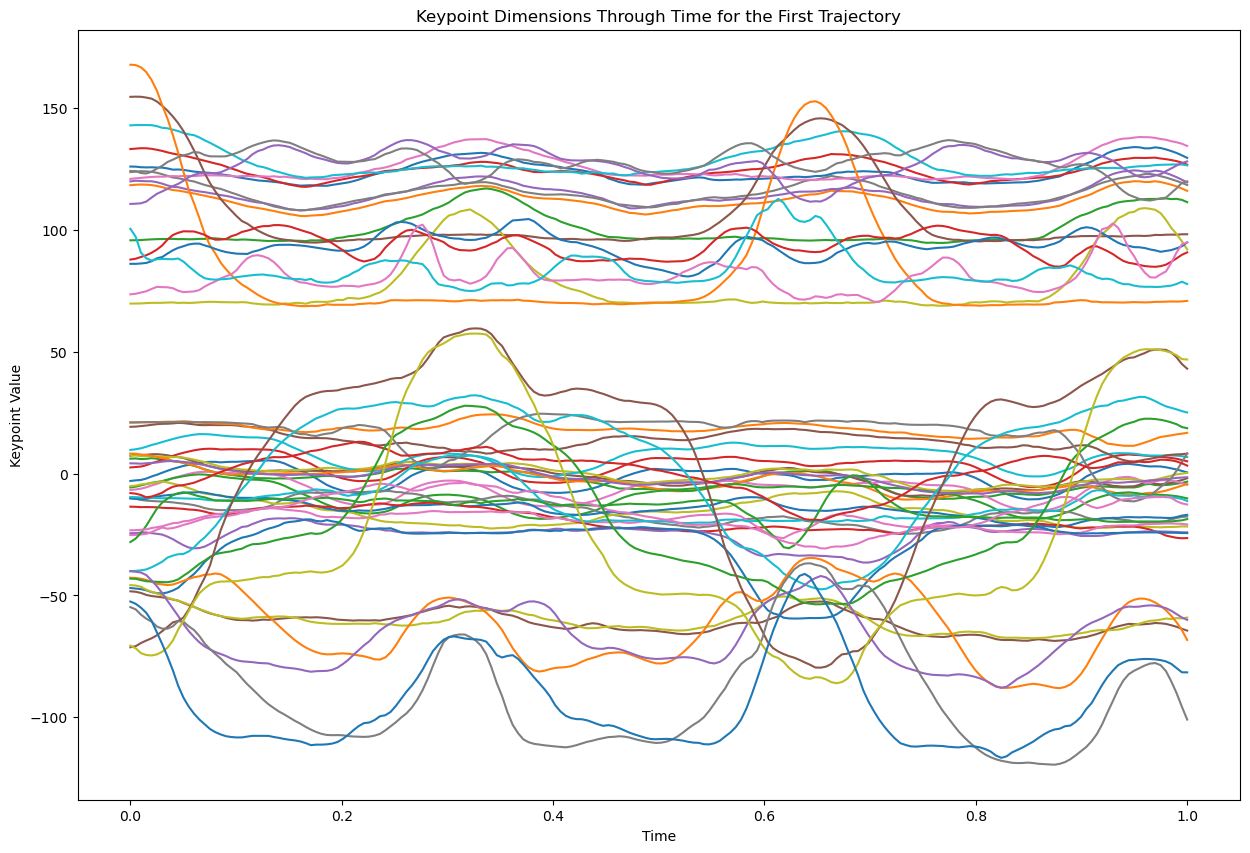

In [9]:
# Extract the first trajectory
first_trajectory = dset.data[0]
print(first_trajectory.shape)  # Should be (200, 34) for 2d case


# Assuming the first column is time and the rest are keypoint dimensions
time = first_trajectory[:, 0]  # First column for time
keypoint_data = first_trajectory[:, 1:]  # The remaining columns for keypoints

# Plot each dimension of the keypoints across time
plt.figure(figsize=(15, 10))

for i in range(keypoint_data.shape[1]):
    plt.plot(time, keypoint_data[:, i], label=f'Keypoint {i+1}')

plt.title('Keypoint Dimensions Through Time for the First Trajectory')
plt.xlabel('Time')
plt.ylabel('Keypoint Value')
#plt.legend()  # This may create a very large legend if there are many keypoints. Consider commenting this out if it's too cluttered.
plt.show()


In [11]:
model=LocallyWeightedCNP((1, 51), hidden_size=256, num_hidden_layers=6, min_std=0.0001).to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
model.load_state_dict(torch.load("/home/colors/LW_CNMP_everything/trained_models/cnp_dance_3d_0.pt"))

RuntimeError: Error(s) in loading state_dict for LocallyWeightedCNP:
	Unexpected key(s) in state_dict: "encoder.0.weight", "encoder.0.bias". 
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 52]).
	size mismatch for query.12.weight: copying a param with shape torch.Size([102, 256]) from checkpoint, the shape in current model is torch.Size([100, 256]).
	size mismatch for query.12.bias: copying a param with shape torch.Size([102]) from checkpoint, the shape in current model is torch.Size([100]).

torch.Size([16, 9, 52]) torch.Size([16, 16, 52]) torch.Size([16, 9]) torch.Size([16, 16])


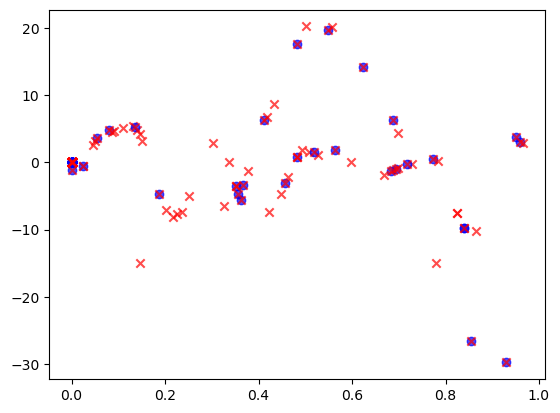

In [17]:
x_t, y_t, x_mask, y_mask = dset.get_sample(16, max_context=10, max_target=10)
print(x_t.shape, y_t.shape, x_mask.shape, y_mask.shape)
for i in range(8):
    plt.scatter(x_t[i, :, 0], x_t[i, :, 1], marker="o", c="b", alpha=0.7)
    plt.scatter(y_t[i, :, 0], y_t[i, :, 1], marker="x", c="r", alpha=0.7)
    # plt.xlim((-2.2, 2.2))
# plt.ylim((-2.2, 2.2))

In [21]:
loss_checkpoint = 1000
loss_inform_checkpoint = 1000
plot_checkpoint = 10000

avg_loss = 0.0
for step in range(2000000):
    x_t, y_t, x_m, y_m = dset.get_sample(16, max_context=5, max_target=10)
    x_t = x_t.to(device)
    y_t = y_t.to(device)
    x_m = x_m.to(device)
    y_m = y_m.to(device)
    optimizer.zero_grad()
    #print(x_t.shape, y_t.shape, x_m.shape, y_m.shape)
    loss = model.nll_loss(x_t, y_t[..., :1], y_t[..., 1:], x_m, y_m)
    #if loss.item()< 1000:
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()

    if step % 1000 == 0:
        print(f"Step {step}, loss: {avg_loss / 1000}")
        avg_loss = 0.0

    if step % 10000 == 0:
        torch.save(model.state_dict(), 'cnp_dance_3d_0.pt')

Step 0, loss: 5.01585888671875
Step 1000, loss: 205.3786867852211
Step 2000, loss: 3.35062646484375
Step 3000, loss: 3.3479283187389375
Step 4000, loss: 3.3481773660182954
Step 5000, loss: 3.3464944353103636
Step 6000, loss: 3.3478577687740327
Step 7000, loss: 3.3482301986217498
Step 8000, loss: 3.349679735660553
Step 9000, loss: 3.348268180131912
Step 10000, loss: 3.3495208220481874
Step 11000, loss: 3.3493617689609527
Step 12000, loss: 3.349293830156326
Step 13000, loss: 3.3485396156311036
Step 14000, loss: 3.3497390632629394
Step 15000, loss: 3.349035743713379
Step 16000, loss: 3.34944424033165
Step 17000, loss: 3.3485634398460387
Step 18000, loss: 3.3494696044921874
Step 19000, loss: 3.349708419084549
Step 20000, loss: 3.349815585374832
Step 21000, loss: 3.35060160279274
Step 22000, loss: 3.348719444990158
Step 23000, loss: 3.348776112794876
Step 24000, loss: 3.343698935031891
Step 25000, loss: 3.3176519095897676
Step 26000, loss: 3.232186873435974
Step 27000, loss: 3.2201331086158

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'observation' is already defined and on the correct device
# 'target' tensor is defined as in your snippet and moved to the correct device
target = torch.linspace(0.0, 1.0, 200).unsqueeze(-1).unsqueeze(0).to(device)

with torch.no_grad():
    mean, std = model(observation, target, locally_weighted=True, aggregation_std=0.5)
    # If you have other variations of the model call, you can use them as needed.

# Squeeze the unnecessary dimensions if your model outputs extra batch dimensions
mean.squeeze_(0)
std.squeeze_(0)

# Now we plot the predictions
# We assume that 'trainset.data' contains the actual data and is compatible with the predictions
for d in trainset.data:
    # Plot the actual data
    plt.plot(d[:, 0], d[:, 1:], label='Actual Data')  # Adjust indices based on your actual data format

# Plot the model's mean predictions; adjust indices if your data has a different format
plt.plot(target.cpu().numpy(), mean.cpu().numpy(), label='Model Predictions', color='red')

# Optionally, you can fill between mean ± std to show the uncertainty
plt.fill_between(target.cpu().numpy().flatten(),
                 (mean - std).cpu().numpy().flatten(),
                 (mean + std).cpu().numpy().flatten(),
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.legend()
plt.show()


In [22]:
torch.save(model.state_dict(), 'cnp_dance_3d_0.pt')

In [46]:
# Load the pickle file
file_path = '/home/colors/aist_lw/aistplusplus_api-main/3d_keypoint_pkls/gBR_sBM_cAll_d04_mBR0_ch01.pkl'

# Reading the pickle file
with open(file_path, 'rb') as file:
    keypoints_data = pickle.load(file)

# Verify the contents of the loaded pickle file
keypoints_data.keys()

dict_keys(['keypoints3d', 'keypoints3d_optim'])

In [47]:
# Check the shape and type of the keypoints3d_optim data
keypoints3d_optim_shape = keypoints_data['keypoints3d_optim'].shape
keypoints3d_optim_type = type(keypoints_data['keypoints3d_optim'])

keypoints3d_optim_shape, keypoints3d_optim_type

((720, 17, 3), numpy.ndarray)

In [20]:
# Define the connections between keypoints for the stick figure
# These connections are based on the COCO-format keypoint definition provided
skeleton_connections = [
    (0, 1), (0, 2), (1, 3), (2, 4), # Head to ears
    (5, 6), (5, 7), (7, 9), # Left arm
    (6, 8), (8, 10), # Right arm
    (11, 12), (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 11), (6, 12), # Body (shoulder to hip)
    (5, 6), (11, 12) # Shoulders and hips
]

# Extract the first frame from the optimized keypoints
first_frame_keypoints = keypoints_data['keypoints3d_optim'][0]

# Plot the first frame
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the aspect ratio to equal for x, y, z axes
ax.set_box_aspect([1,1,1])

# Plotting each connection line
for connection in skeleton_connections:
    point1 = first_frame_keypoints[connection[0], :]
    point2 = first_frame_keypoints[connection[1], :]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    z_values = [point1[2], point2[2]]
    ax.plot(x_values, y_values, z_values, 'ro-')

# Setting the labels for the axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()


In [22]:
# Create a new figure for the 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting each connection line in 2D (using X and Y coordinates)
for connection in skeleton_connections:
    point1 = first_frame_keypoints[connection[0], :]
    point2 = first_frame_keypoints[connection[1], :]
    x_values = [point1[0], point2[0]]  # Use the original X for the 2D x-axis
    y_values = [point1[1], point2[1]]  # Use the original Y for the 2D y-axis
    ax.plot(x_values, y_values, 'ro-')

# Annotating each keypoint with its label in 2D
for i, keypoint in enumerate(first_frame_keypoints):
    ax.text(keypoint[0], keypoint[1], keypoint_labels[i], color='blue')

# Setting the labels for the axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

# Show the plot
plt.show()


In [15]:


# Extract all frames from the optimized keypoints
all_frames_keypoints = keypoints_data['keypoints3d_optim']

# Create a new figure for the animation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Set the aspect ratio to equal for the new x, y, z axes
ax.set_box_aspect([1,1,1])

# Initialize the plot with the first frame (for the animation)
lines = []
for connection in skeleton_connections:
    point1 = all_frames_keypoints[0][connection[0], :]
    point2 = all_frames_keypoints[0][connection[1], :]
    line, = ax.plot([point1[1], point2[1]], [point1[2], point2[2]], [point1[0], point2[0]], 'ro-')
    lines.append(line)

# This function will be called for each frame of the animation
def update(frame):
    for line, connection in zip(lines, skeleton_connections):
        point1 = all_frames_keypoints[frame][connection[0], :]
        point2 = all_frames_keypoints[frame][connection[1], :]
        line.set_data([point1[1], point2[1]], [point1[2], point2[2]])  # Update the data for X and Y
        line.set_3d_properties([point1[0], point2[0]])  # Update the data for Z
    return lines

# Create the animation
ani = FuncAnimation(fig, update, frames=len(all_frames_keypoints), interval=1000/60, blit=True)

# Setting the labels for the axes with new orientation
ax.set_xlabel('Y axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('X axis')

# Save the animation as an MP4 file
mp4_file_path = 'skeleton_animation.mp4'
ani.save(mp4_file_path, writer='ffmpeg', fps=60)

mp4_file_path


'skeleton_animation.mp4'

In [58]:
%matplotlib qt
# Load the pickle file
file_path = '/home/colors/aist_lw/aistplusplus_api-main/3d_keypoint_pkls/gBR_sBM_cAll_d04_mBR0_ch01.pkl'

# Reading the pickle file
with open(file_path, 'rb') as file:
    keypoints_data = pickle.load(file)
# Extract all frames from the optimized keypoints
all_frames_keypoints = keypoints_data['keypoints3d_optim']
# Define the connections between keypoints for the stick figure
# These connections are based on the COCO-format keypoint definition provided
skeleton_connections = [
    (0, 1), (0, 2), (1, 3), (2, 4), # Head to ears
    (5, 6), (5, 7), (7, 9), # Left arm
    (6, 8), (8, 10), # Right arm
    (11, 12), (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 11), (6, 12), # Body (shoulder to hip)
    (5, 6), (11, 12) # Shoulders and hips
]

# COCO-format keypoint definition
keypoint_labels = [
    "nose", 
    "left_eye", "right_eye", "left_ear", "right_ear", 
    "left_shoulder", "right_shoulder", 
    "left_elbow", "right_elbow", 
    "left_wrist", "right_wrist", 
    "left_hip", "right_hip", 
    "left_knee", "right_knee", 
    "left_ankle", "right_ankle"
]

# Reduce the number of frames for the animation to limit processing time
# We will sample every 10th frame to reduce the number of frames
frame_skip = 1
reduced_frames_keypoints = all_frames_keypoints[::frame_skip]

# Define the update function for the animation with reduced frames
def update(frame_number, keypoints, lines, annotations):
    for line, connection in zip(lines, skeleton_connections):
        point1 = keypoints[frame_number][connection[0], :]
        point2 = keypoints[frame_number][connection[1], :]
        line.set_data([point1[0], point2[0]], [point1[1], point2[1]])
    for annotation, keypoint in zip(annotations, keypoints[frame_number]):
        annotation.set_position((keypoint[0], keypoint[1]))
    return lines + annotations

# Create a new figure for the 2D animation with reduced frames
fig, ax = plt.subplots(figsize=(10, 8))

# Initialize the lines and points for the animation
lines = []
annotations = []
for connection in skeleton_connections:
    line, = ax.plot([], [], 'ro-')
    lines.append(line)
for i in range(len(keypoint_labels)):
    annotation = ax.text(0, 0, keypoint_labels[i], color='blue')
    annotations.append(annotation)

# Set the plot limits
ax.set_xlim(np.min(reduced_frames_keypoints[:,:,0]), np.max(reduced_frames_keypoints[:,:,0]))
ax.set_ylim(np.min(reduced_frames_keypoints[:,:,1]), np.max(reduced_frames_keypoints[:,:,1]))

# Set the labels for the axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

# Creating the 2D animation with reduced frames
ani_2d_reduced = FuncAnimation(fig, update, frames=len(reduced_frames_keypoints),
                               fargs=(reduced_frames_keypoints, lines, annotations),
                               interval=1000/60 * frame_skip, blit=True)

# Save the animation as an MP4 file
mp4_file_path_2d_reduced = '2d_skeleton_animation_reduced.mp4'
ani_2d_reduced.save(mp4_file_path_2d_reduced, writer='ffmpeg', fps=60 // frame_skip)

mp4_file_path_2d_reduced


'2d_skeleton_animation_reduced.mp4'

In [60]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the connections between keypoints for the stick figure
skeleton_connections = [
    (0, 1), (0, 2), (1, 3), (2, 4), # Head to ears
    (5, 6), (5, 7), (7, 9), # Left arm
    (6, 8), (8, 10), # Right arm
    (11, 12), (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 11), (6, 12), # Body (shoulder to hip)
    (5, 6), (11, 12) # Shoulders and hips
]

# COCO-format keypoint definition
keypoint_labels = [
    "nose", 
    "left_eye", "right_eye", "left_ear", "right_ear", 
    "left_shoulder", "right_shoulder", 
    "left_elbow", "right_elbow", 
    "left_wrist", "right_wrist", 
    "left_hip", "right_hip", 
    "left_knee", "right_knee", 
    "left_ankle", "right_ankle"
]
num_keypoints = len(keypoint_labels)
# Function to update the animation for the saved MP4
def update_animation_2d(frame_number, keypoints, lines, annotations):
    for line, connection in zip(lines, skeleton_connections):
        point1 = keypoints[frame_number][connection[0], :]
        point2 = keypoints[frame_number][connection[1], :]
        line.set_data([point1[0], point2[0]], [point1[1], point2[1]])
    for annotation, keypoint in zip(annotations, keypoints[frame_number]):
        annotation.set_position((keypoint[0], keypoint[1]))
    return lines + annotations

# Function to visualize the trajectory for PyTorch tensor data and save as MP4
def save_trajectory_animation_2d(index, dataset, file_path):
    # Extract the trajectory for the specified index
    trajectory_tensor = dataset.data[index]
    # Convert the PyTorch tensor to a numpy array and skip the first value (time)
    trajectory_keypoints = trajectory_tensor.numpy()[:, 1:].reshape(-1, num_keypoints, 3)

    # Create a figure for the animation
    fig, ax = plt.subplots(figsize=(10, 8))

    # Initialize the lines and points for the animation
    lines = []
    annotations = []
    for connection in skeleton_connections:
        # Initialize line with the first frame data
        point1 = trajectory_keypoints[0][connection[0], :]
        point2 = trajectory_keypoints[0][connection[1], :]
        line, = ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'ro-')
        lines.append(line)
    for i, label in enumerate(keypoint_labels):
        # Initialize annotation with the first frame data
        annotation = ax.text(*trajectory_keypoints[0, i, :], label, color='blue')
        annotations.append(annotation)

    # Set the plot limits
    ax.set_xlim(np.min(trajectory_keypoints[:,:,0]), np.max(trajectory_keypoints[:,:,0]))
    ax.set_ylim(np.min(trajectory_keypoints[:,:,1]), np.max(trajectory_keypoints[:,:,1]))

    # Set the labels for the axes
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')

    # Creating the 2D animation
    ani = FuncAnimation(fig, update_animation_2d, frames=len(trajectory_keypoints),
                        fargs=(trajectory_keypoints, lines, annotations),
                        interval=1000/60, blit=True)

    # Save the animation as an MP4 file
    ani.save(file_path, writer='ffmpeg', fps=60)

    plt.close(fig)  # Close the figure to avoid displaying it inline

# Define the file path for the MP4
mp4_file_path_2d = '2d_skeleton_animation_new.mp4'

# Save the first trajectory animation as a 2D MP4
save_trajectory_animation_2d(0, dset, mp4_file_path_2d)

# Return the file path for download
mp4_file_path_2d


'2d_skeleton_animation_new.mp4'

In [15]:

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
import pickle


# Define the connections between keypoints for the stick figure
skeleton_connections = [
    (0, 1), (0, 2), (1, 3), (2, 4), # Head to ears
    (5, 6), (5, 7), (7, 9), # Left arm
    (6, 8), (8, 10), # Right arm
    (11, 12), (11, 13), (13, 15), # Left leg
    (12, 14), (14, 16), # Right leg
    (5, 11), (6, 12), # Body (shoulder to hip)
    (5, 6), (11, 12) # Shoulders and hips
]

# COCO-format keypoint definition
keypoint_labels = [
    "nose", 
    "left_eye", "right_eye", "left_ear", "right_ear", 
    "left_shoulder", "right_shoulder", 
    "left_elbow", "right_elbow", 
    "left_wrist", "right_wrist", 
    "left_hip", "right_hip", 
    "left_knee", "right_knee", 
    "left_ankle", "right_ankle"
]
num_keypoints = len(keypoint_labels)




# Define the connections and labels as before

def update_animation_3d(frame_number, keypoints, lines, annotations):
    for line, connection in zip(lines, skeleton_connections):
        point1 = keypoints[frame_number][connection[0], :]
        point2 = keypoints[frame_number][connection[1], :]
        line.set_data([point1[0], point2[0]], [point1[1], point2[1]])
        line.set_3d_properties([point1[2], point2[2]])  # Update for 3D properties
    for annotation, keypoint in zip(annotations, keypoints[frame_number]):
        annotation.set_position((keypoint[0], keypoint[1]))
        annotation.set_3d_properties(keypoint[2])  # Update for 3D properties
    return lines + annotations

def save_trajectory_animation_3d(index, dataset, file_path):
    trajectory_tensor = dataset.data[index]
    trajectory_keypoints = trajectory_tensor.numpy()[:, 1:].reshape(-1, num_keypoints, 3)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
    ax.view_init(elev=90, azim=270)
    lines = []
    annotations = []
    for connection in skeleton_connections:
        point1 = trajectory_keypoints[0][connection[0], :]
        point2 = trajectory_keypoints[0][connection[1], :]
        line, = ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], 'ro-')
        lines.append(line)
    for i, label in enumerate(keypoint_labels):
        annotation = ax.text(*trajectory_keypoints[0, i, :], label, color='blue')
        annotations.append(annotation)

    ax.set_xlim(np.min(trajectory_keypoints[:,:,0]), np.max(trajectory_keypoints[:,:,0]))
    ax.set_ylim(np.min(trajectory_keypoints[:,:,1]), np.max(trajectory_keypoints[:,:,1]))
    ax.set_zlim(np.min(trajectory_keypoints[:,:,2]), np.max(trajectory_keypoints[:,:,2]))
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    ani = FuncAnimation(fig, update_animation_3d, frames=len(trajectory_keypoints),
                        fargs=(trajectory_keypoints, lines, annotations),
                        interval=1000/60, blit=False)

    ani.save(file_path, writer='ffmpeg', fps=60)

    #plt.close(fig)

mp4_file_path_3d = '3d_skeleton_animation.mp4'
save_trajectory_animation_3d(0, dset, mp4_file_path_3d)
mp4_file_path_3d


'3d_skeleton_animation.mp4'

In [23]:
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch

# Assuming 'mean' is your model's output for the keypoints predictions
# Adjust the shape of predicted_keypoints for 3D (num_frames, num_keypoints, 3)
predicted_keypoints = mean.cpu().numpy().reshape(-1, 17, 3)

def animate_predictions_3d(predictions):
    # Create a new figure for the 3D animation
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=90, azim=270)

    # Initialize the lines for the 3D animation
    lines = []
    for connection in skeleton_connections:
        line, = ax.plot([], [], [], 'ro-')
        lines.append(line)

    # Set the limits for the plot
    ax.set_xlim(np.min(predictions[:,:,0]), np.max(predictions[:,:,0]))
    ax.set_ylim(np.min(predictions[:,:,1]), np.max(predictions[:,:,1]))
    ax.set_zlim(np.min(predictions[:,:,2]), np.max(predictions[:,:,2]))

    # Define the update function for the 3D animation
    def update(frame_number):
        for line, connection in zip(lines, skeleton_connections):
            point1 = predictions[frame_number][connection[0], :]
            point2 = predictions[frame_number][connection[1], :]
            line.set_data([point1[0], point2[0]], [point1[1], point2[1]])
            line.set_3d_properties([point1[2], point2[2]])
        return lines

    # Creating the 3D animation
    ani = FuncAnimation(fig, update, frames=len(predictions),
                        interval=500/60, blit=False)

    # Display the animation
    plt.show()

    return ani

# Call the function with your model's output
animation_3d = animate_predictions_3d(predicted_keypoints)

# If you want to save the animation, you can do so with the save method:
animation_3d.save('predicted_animation_3d.mp4', writer='ffmpeg', fps=60)
